In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import os, os.path

import cv2
import PIL

use_cuda=True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data Loading

In [0]:
from zipfile import ZipFile
# import urllib.request
# url = 'https://github.com/SarhadSalam/APS360_Final_Project/blob/master/sample_data/trousers.zip'
file_name = "trousers.zip"
# urllib.request.urlretrieve(url, file_name)
ZipFile(file_name).extractall()

In [2]:
# Real dir: 'whatever/', the ending / is important
class EdgeRealDataset(torch.utils.data.Dataset):
    def __init__(self, real_dir, edge_dir, transform = None):
        self.real_dir = real_dir
        self.edge_dir = edge_dir
        self.transform = transform
        self.count = len([n for n in os.listdir(real_dir) if os.path.isfile(real_dir + n)])
    
    def __len__(self):
        return self.count
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        real_img = cv2.imread(self.real_dir+str(idx)+'.png')
        real_img = cv2.cvtColor(real_img, cv2.COLOR_BGRA2RGBA) # test if the actual
        
        edge_img = cv2.imread(self.edge_dir+str(idx)+'.png')
        edge_img = cv2.cvtColor(edge_img, cv2.COLOR_BGRA2RGBA) # test if the actual
        
        if self.transform:
            real_img = self.transform(real_img)
            edge_img = self.transform(edge_img)
        
        return (real_img, edge_img)

In [3]:
transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))         
         ])
data_set = EdgeRealDataset('./sample_data/trousers/filtered/', './sample_data/trousers/whites/', transform=transform)
print("Number of data points is {}".format(len(data_set)))

Number of data points is 661


In [29]:
def get_data_loader(data_set, batch_size, data_samples = -1):
    """ Generates training, validation and testing data loader for the relevant 
    target classes for a given batch size.

    Args:
        full_data_set: Dataset object containing data points to be split into 
                        training, validation and test put into data loaders
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: size per batch
        data_samples: integer number of data samples to use, defaults to -1 to use all
                      data points
    Returns:
        training, validation and testing data loaders with a distribution of 
        60:30:10
    """
  
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    torch.manual_seed(1000)

    # dataset = EdgeRealDataset(full_data_set)

    num_samples = len(data_set)
    #num_samples = 5

    # Randomize indices list
    indices = list(range(num_samples))
    # np.random.shuffle(indices)

    train_sampler = SubsetRandomSampler(indices)

    train_loader = DataLoader(data_set, batch_size=batch_size,
                                num_workers=2, sampler=train_sampler)
    
    return train_loader

In [26]:
train_loader = get_data_loader(data_set, 1)

In [30]:
if __name__ == '__main__':
    k = 0
    for edges, reals in train_loader:
      # since batch_size = 1, there is only 1 image in `images`
      # print(image[0:3].shape)
      # noise = np.random.uniform(-0.25, 0.25, size=edges[0][0:3].shape)
      # noise = torch.from_numpy(noise).float()
      # edges[0][0:3] += noise
      # edges[0][0:3] = (edges[0][0:3]+0.25)/1.5

      image = torch.cat((edges[0], reals[0]), 2)

      # image[] /= 2
      # image += 1
      #image = edges[0]
      # place the colour channel at the end, instead of at the beginning
      img = np.transpose(image, [1,2,0])
      # normalize pixel intensity values to [0, 1]
      #img = img / 2 + 0.5
      plt.subplot(3, 5, k+1)
      plt.axis('off')
      plt.imshow(img)

      k += 1
      if k > 5:
        break

RuntimeError: DataLoader worker (pid(s) 3664) exited unexpectedly

# GAN Architecture

In [16]:
class Generator(nn.Module):
  def __init__(self, name):
    super(Generator, self).__init__()
    self.name = name
    self.encoder= nn.Sequential(
      nn.Conv2d(4, 16, 3, stride=2, padding=1),
      nn.BatchNorm2d(16),
      nn.LeakyReLU(),
      nn.Conv2d(16, 32, 3, stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.LeakyReLU(),
      nn.Conv2d(32, 64, 7),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(),
      nn.Conv2d(64, 128, 5)
    )
    self.decoder= nn.Sequential(
      nn.ConvTranspose2d(128, 64, 5),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(),
      nn.ConvTranspose2d(64, 32, 7),
      nn.BatchNorm2d(32),
      nn.LeakyReLU(),
      nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
      nn.BatchNorm2d(16),
      nn.LeakyReLU(),
      nn.ConvTranspose2d(16, 4, 3, stride=2, padding=1, output_padding=1),
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [17]:
class Discriminator(nn.Module):
  def __init__(self, name="cnn"):
    super(Discriminator,self).__init__()
    self.name = name

    in_ch1 = 4
    out_ch1 = 8
    kern_sz1 = 5
    stride1 = 1
    padding1 = 0

    pool1_kern_sz = 4
    pool1_stride = 4
    pool1_padding = 0

    in_ch2 = out_ch1
    out_ch2 = 16
    kern_sz2 = 5
    stride2 = 1
    padding2 = 0

    pool2_kern_sz = 2
    pool2_stride = 2
    pool2_padding = 0

    in_ch3 = out_ch2
    out_ch3 = 32
    kern_sz3 = 4
    stride3 = 1
    padding3 = 0      

    # Calculate size of output after convolution layers
    fc1_in_sz = 1 + int((400 + 2*padding1 - kern_sz1)/stride1)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*pool1_padding - pool1_kern_sz) / pool1_stride)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*padding2 - kern_sz2)/stride2)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*pool2_padding - pool2_kern_sz) / pool2_stride)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*padding3 - kern_sz3)/stride3)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*pool2_padding - pool2_kern_sz) / pool2_stride)

    fc1_in_sz2 = 1 + int((100 + 2*padding1 - kern_sz1)/stride1)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*pool1_padding - pool1_kern_sz) / pool1_stride)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*padding2 - kern_sz2)/stride2)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*pool2_padding - pool2_kern_sz) / pool2_stride)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*padding3 - kern_sz3)/stride3)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*pool2_padding - pool2_kern_sz) / pool2_stride)

    self.fc1_in_sz = out_ch3 * fc1_in_sz * fc1_in_sz2 # need to store on self for use in forward

    fc1_out_sz = 16

    fc2_in_sz = fc1_out_sz
    fc2_out_sz = 1

    # Three convolution layers (+ max pool)
    self.conv1 = nn.Conv2d(in_ch1, out_ch1, kern_sz1, stride1, padding1)
    self.pool1 = nn.MaxPool2d(pool1_kern_sz, pool1_stride, pool1_padding)
    self.conv2 = nn.Conv2d(in_ch2, out_ch2, kern_sz2, stride2, padding2)
    self.pool2 = nn.MaxPool2d(pool2_kern_sz, pool2_stride, pool2_padding)
    self.conv3 = nn.Conv2d(in_ch3, out_ch3, kern_sz3, stride3, padding3)
    
    # Two fully connected layers
    self.fc1 = nn.Linear(self.fc1_in_sz, fc1_out_sz)
    self.fc2 = nn.Linear(fc2_in_sz, fc2_out_sz)

  def forward(self, x):
    x = torch.cat([x[0], x[1]], dim=2)
    x = self.pool1(F.leaky_relu(self.conv1(x), 0.2))
    x = self.pool2(F.leaky_relu(self.conv2(x), 0.2))
    x = self.pool2(F.leaky_relu(self.conv3(x), 0.2))
    x = x.view(-1, self.fc1_in_sz)
    x = F.relu(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    return x

In [18]:
def get_model_path(model, batch_size, learning_rate, num_epoch):
  return "model_{}_bs_{}_lr_{}_epoch_{}".format(model.name, batch_size,
                                                learning_rate, num_epoch)

In [19]:
def train(G, D, batch_size=512, learning_rate=0.001, num_epochs=5):
  np.random.seed(1000)
  torch.manual_seed(1000)

  if use_cuda and torch.cuda.is_available():
    G = G.cuda()
    D = D.cuda()
    print('CUDA is available! Training on GPU')

  criterion_D = nn.BCELoss()
  optimizer_D = optim.Adam(D.parameters(), lr=learning_rate, weight_decay=1e-5)
  criterion_G = nn.BCELoss()
  optimizer_G = optim.Adam(G.parameters(), lr=learning_rate, weight_decay=1e-5)

  train_loader = get_data_loader(data_set, batch_size)
  print("Loaded training data with {} samples".format(len(train_loader.dataset)))
  real_labels = torch.ones(batch_size, 1)
  fake_labels = torch.zeros(batch_size, 1)

  model_store_interval = 10
  
  D_losses, D1_losses, D2_losses, G_losses, iterations = [], [], [], [], []
  print("Started training")
  iteration = 0
  for epoch in range(num_epochs):
    print("Starting epoch", epoch+1)
    for i, (source_real, target_real) in enumerate(train_loader, 0):
      iteration += 1
      optimizer_D.zero_grad()

      real_labels = torch.ones(source_real.shape[0], 1)
      fake_labels = torch.zeros(source_real.shape[0], 1)

      if use_cuda and torch.cuda.is_available():
        real_labels = real_labels.cuda()
        fake_labels = fake_labels.cuda()

      #TODO try adding some noise to input before passing through generator
      noise = np.random.uniform(-0.25, 0.25, size=source_real.shape)
      noise = torch.from_numpy(noise).float()
      source_real[:][0:3] += noise[:][0:3]
      source_real[:][0:3] = (source_real[:][0:3]+0.25)/1.5
      # print(source_real.shape)
      # return

      if use_cuda and torch.cuda.is_available():
          source_real = source_real.cuda()
          target_real = target_real.cuda()

      out_D1 = D([source_real, target_real])
      # print(out_D1.shape)
      # print([source_real, target_real].shape)
      if use_cuda and torch.cuda.is_available():
        out_D1 = out_D1.cuda()

      loss_D1 = criterion_D(out_D1, real_labels)

      target_fake = G(source_real)

      if use_cuda and torch.cuda.is_available():
        target_fake = target_fake.cuda()

      # if use_cuda and torch.cuda.is_available():
      #     target_fake = target_fake.cuda()

      out_D2 = D([source_real, target_fake.detach()])

      if use_cuda and torch.cuda.is_available():
        out_D2 = out_D2.cuda()

      loss_D2 = criterion_D(out_D2, fake_labels)

      loss_D = (loss_D1 + loss_D2) / 2
      loss_D.backward()
      optimizer_D.step()

      optimizer_G.zero_grad()

      out_D3 = D([source_real, target_fake])

      if use_cuda and torch.cuda.is_available():
        out_D3 = out_D3.cuda()

      loss_G = criterion_G(out_D3, real_labels)
      loss_G.backward()
      optimizer_G.step()

      # Save loss data
      if iteration % 50 == 0:
        iterations.append(iteration)
        D_losses.append(loss_D)
        G_losses.append(loss_G)
        print("Iteration #{} |\t D_loss: {} |\t G_loss: {}".format(iteration, D_losses[-1], G_losses[-1]))

    if (epoch == num_epochs-1 or (epoch+1) % model_store_interval == 0):
      model_path = get_model_path(D, batch_size, learning_rate, epoch)
      torch.save(D.state_dict(), model_path)
      model_path = get_model_path(G, batch_size, learning_rate, epoch)
      torch.save(G.state_dict(), model_path)

  print("Finished training")

  # Plots
  plt.title("D Losses")
  plt.plot(iterations, D_losses, label="D")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("G Losses")
  plt.plot(iterations, G_losses, label="G")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [23]:
bs = 128
lr = 0.001
ne = 25

use_cuda = False

generator = Generator("gen")
discriminator = Discriminator("dis")

train(generator, discriminator, bs, lr, ne)

Loaded training data with 661 samples
Started training
Starting epoch 1
Starting epoch 2


KeyboardInterrupt: 

CUDA is available! Training on GPU
Loaded training data with 661 samples
Started training
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Iteration #50 |	 D_loss: 0.566338837146759 |	 G_loss: 0.733037531375885
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Iteration #100 |	 D_loss: 0.6083752512931824 |	 G_loss: 0.8217398524284363
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Iteration #150 |	 D_loss: 0.508536696434021 |	 G_loss: 4.331717491149902
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Iteration #200 |	 D_loss: 0.22935515642166138 |	 G_loss: 3.174034595489502
Starting epo

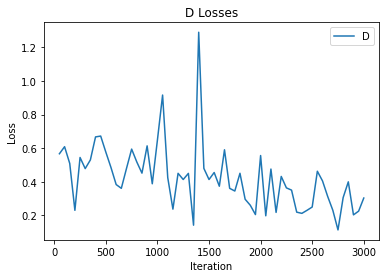

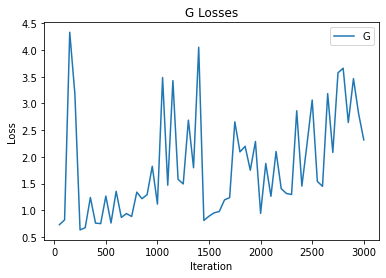

In [136]:
train(generator, discriminator, bs, lr, ne)

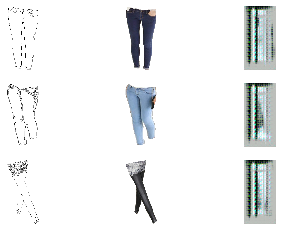

In [22]:
# Plot images for m to n

m, n = 0, 3
for i in range (m, n):
  test_edge_img = plt.imread('sample_data/trousers/whites/' + str(i)+ '.png')
  test_real_img = plt.imread('sample_data/trousers/filtered/' + str(i)+ '.png')
  test_edge_img_inp = torch.tensor(np.transpose(test_edge_img, [2, 0, 1]))
  test_edge_img_inp = test_edge_img_inp.reshape([1, *test_edge_img_inp.shape])

  if use_cuda and torch.cuda.is_available():
    test_edge_img_inp = test_edge_img_inp.cuda()

  out = generator(test_edge_img_inp)
  if use_cuda and torch.cuda.is_available():
    out = out.cpu().detach().numpy().squeeze(0)
  else:
    out = out.detach().numpy().squeeze(0)
  out = np.transpose(out, [1, 2, 0])

  plt.subplot(n-m, 3, 3 * (i-m) + 1)
  plt.axis('off')
  plt.imshow(test_edge_img)

  plt.subplot(n-m, 3, 3 * (i-m) + 2)
  plt.axis('off')
  plt.imshow(test_real_img)

  plt.subplot(n-m, 3, 3 * (i-m) + 3)
  plt.axis('off')
  plt.imshow(out)

In [0]:
def display_img_from_training(index):
  print("Plotting {}.png".format(index))

  test_edge_img = plt.imread('trousers/whites/' + str(index)+ '.png')
  test_real_img = plt.imread('trousers/filtered/' + str(index)+ '.png')
  test_edge_img_inp = torch.tensor(np.transpose(test_edge_img, [2, 0, 1]))
  test_edge_img_inp = test_edge_img_inp.reshape([1, *test_edge_img_inp.shape])

  if use_cuda and torch.cuda.is_available():
    test_edge_img_inp = test_edge_img_inp.cuda()

  out = generator(test_edge_img_inp)
  if use_cuda and torch.cuda.is_available():
    out = out.cpu().detach().numpy().squeeze(0)
  else:
    out = out.detach().numpy().squeeze(0)
  out = np.transpose(out, [1, 2, 0])

  plt.subplot(1, 3, 1)
  plt.title("Input")
  plt.axis('off')
  plt.imshow(test_edge_img)

  plt.subplot(1, 3, 2)
  plt.title("Actual")
  plt.axis('off')
  plt.imshow(test_real_img)

  plt.subplot(1, 3, 3)
  plt.title("Generated")
  plt.axis('off')
  plt.imshow(out)

In [0]:
def display_img_from_custom(filename):
  print("Plotting " + filename)
  if filename[-4:] == '.png':
    filename = 'test_samples/' + filename
  else:
    filename = 'test_samples/' + filename + '.png'

  test_edge_img = plt.imread(filename)
  test_edge_img_inp = torch.tensor(np.transpose(test_edge_img, [2, 0, 1]))
  test_edge_img_inp = test_edge_img_inp.reshape([1, *test_edge_img_inp.shape])

  if use_cuda and torch.cuda.is_available():
    test_edge_img_inp = test_edge_img_inp.cuda()

  out = generator(test_edge_img_inp)
  if use_cuda and torch.cuda.is_available():
    out = out.cpu().detach().numpy().squeeze(0)
  else:
    out = out.detach().numpy().squeeze(0)
  out = np.transpose(out, [1, 2, 0])

  plt.subplot(1, 2, 1)
  plt.title("Input")
  plt.axis('off')
  plt.imshow(test_edge_img)

  plt.subplot(1, 2, 2)
  plt.title("Generated")
  plt.axis('off')
  plt.imshow(out)

Plotting 46.png


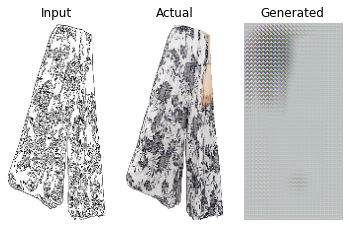

In [83]:
# Plot a random image
import random
i = random.randint(0, len(data_set) // 3)
display_img_from_training(i)

In [18]:
display_img_from_custom("doodle2")

Plotting doodle2


FileNotFoundError: ignored

In [19]:
pred = []
for i, (source_real, target_real) in enumerate(train_loader, 0):
  pred.append(discriminator([source_real.cuda(), target_real.cuda()]))
  if i > 5:
    break

for i, (source_real, target_real) in enumerate(train_loader, 0):
  pred.append(discriminator([source_real.cuda(), generator(source_real.cuda()).detach().cuda()]))
  if i > 5:
    break

pred

[tensor([[0.9964]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9997]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9977]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9977]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9999]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9918]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9771]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0216]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0002]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0007]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0012]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9161]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0110]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.1599]], device='cuda:0', grad_fn=<SigmoidBackward>)]

In [166]:
bs = 128
lr = 0.001
ne = 5

generator = G(4, 4, 128)
discriminator = D(4, 64)

train(generator, discriminator, bs, lr, ne)

CUDA is available! Training on GPU
Loaded training data with 661 samples
Started training
Starting epoch 1


RuntimeError: ignored